<a href="https://colab.research.google.com/github/jojosam90/recommeded_system/blob/main/book_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [321]:
# from google.colab import drive
# drive.mount('/content/drive')

In [341]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset/recommendation_system/book'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/dataset/recommendation_system/book/BX-Users.csv
/content/drive/MyDrive/dataset/recommendation_system/book/BX_Books.csv
/content/drive/MyDrive/dataset/recommendation_system/book/BX-Book-Ratings.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [343]:
books = pd.read_csv('/content/drive/MyDrive/dataset/recommendation_system/book/Preprocessed_data.csv')
books.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0000,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


In [344]:
df = books.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(columns = ['Unnamed: 0','location','isbn',
                   'img_s','img_m','city','age',
                   'state','Language','country',
                   'year_of_publication'],axis=1,inplace = True) #remove useless cols

df.drop(index=df[df['Category'] == '9'].index, inplace=True) #remove 9 in category

df.drop(index=df[df['rating'] == 0].index, inplace=True) #remove 0 in rating

df['Category'] = df['Category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

df.head(2)

,user_id,rating,book_title,book_author,publisher,img_l,Summary,Category
1,8,5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
4,67544,8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses


In [345]:
# Item-based collaborative filtering

def item_based_recommender(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
    
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 180].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'],
                                                    values='rating')
        
            book = user_book_df[book_title]
            recom_data = pd.DataFrame(user_book_df.corrwith(book). \
                                      sort_values(ascending=False)).reset_index(drop=False)
            
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
                
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)
                    
            if recom_data.shape[0] - len(low_rating) > 5:
                recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]
            
            recom_data = recom_data[0:5]    
            recom_data.columns = ['book_title','corr']
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(recom_data['book_title'].tolist())):
        
                url = books.loc[books['book_title'] == recom_data['book_title'].tolist()[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == recom_data['book_title'].tolist()[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
    else:
        print('Cant find book in dataset, please check spelling')

In [346]:
item_based_recommender('Fahrenheit 451')

There are no recommendations for this book
Try: 

To Kill a Mockingbird 

Timeline 



In [347]:
item_based_recommender('The Street Lawyer')

There are no recommendations for this book
Try: 

Timeline 

Bridget Jones's Diary 



In [348]:
item_based_recommender('Divine Secrets of the Ya-Ya Sisterhood: A Novel')

Cant find book in dataset, please check spelling


In [349]:
# COntent-Based Collaborative Filtering

def content_based_recommender(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

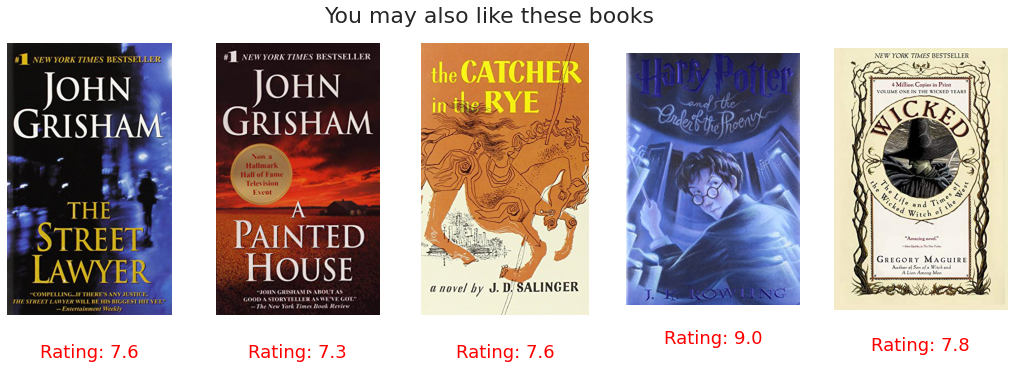

In [350]:
content_based_recommender('The Testament')

In [351]:
content_based_recommender('1st to Die: A Novel')

Cant find book in dataset, please check spelling


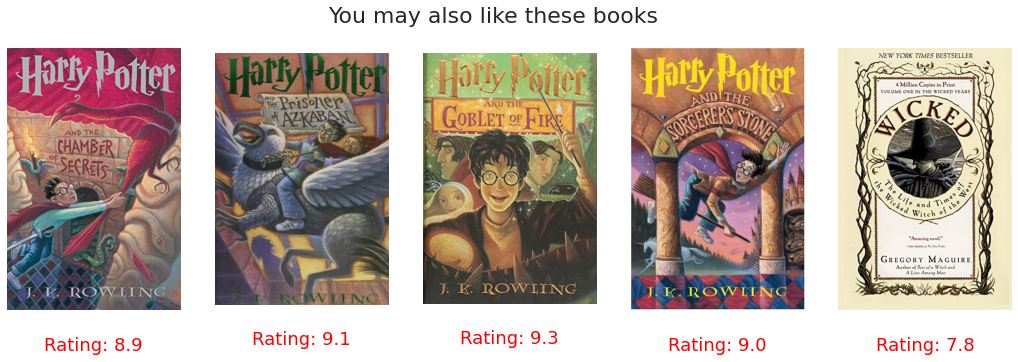

In [352]:
content_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')